In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#columns:['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
#       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
#       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
#       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss']

df = pd.read_csv('./round-2-island-data-bottle/prices_round_2_day_-1.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])

In [2]:
def size_weighted_mid_price(df:pd.DataFrame):
    """
    Calculate the size-weighted mid price.
    :param df: DataFrame containing the data
    :return: Series with the size-weighted mid price
    """
    # Calculate the size-weighted mid price
    bid_volume = df[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].values
    bid_price = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].values
    ask_volume = df[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].values
    ask_price = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].values

    total_bid_volume = np.nansum(bid_volume, axis=1)
    total_bid_value = np.nansum(bid_price * bid_volume, axis=1)
    total_ask_volume = np.nansum(ask_volume, axis=1)
    total_ask_value = np.nansum(ask_price * ask_volume, axis=1)

    size_weighted_mid_price = (total_bid_value + total_ask_value) / (total_bid_volume + total_ask_volume)
    
    return size_weighted_mid_price

In [6]:
from statsmodels.tsa.stattools import adfuller
def adf_stationarity_test(series: pd.Series, n_steps: int = None) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) stationarity test on a time series.
    
    Parameters:
        series (pd.Series): The time series data to test.
        n_steps (int, optional): Number of timesteps (from the start) to use. 
                                 If None, the entire series is used.
    
    Returns:
        dict: A dictionary containing the ADF test statistic, p-value, used lag, 
              number of observations, and critical values.
    """
    # Optionally slice the series to the first n_steps observations.
    if n_steps is not None:
        series = series.iloc[:n_steps]
    
    # Drop NaN values before testing.
    result = adfuller(series.dropna())
    
    # Unpack the results.
    adf_stat = result[0]
    p_value = result[1]
    used_lag = result[2]
    n_obs = result[3]
    crit_values = result[4]
    ic_best = result[5] if len(result) > 5 else None
    
    return {
        "ADF Statistic": adf_stat,
        "p-value": p_value,
        "Used Lag": used_lag,
        "Number of Observations": n_obs,
        "Critical Values": crit_values,
        "IC Best": ic_best
    }


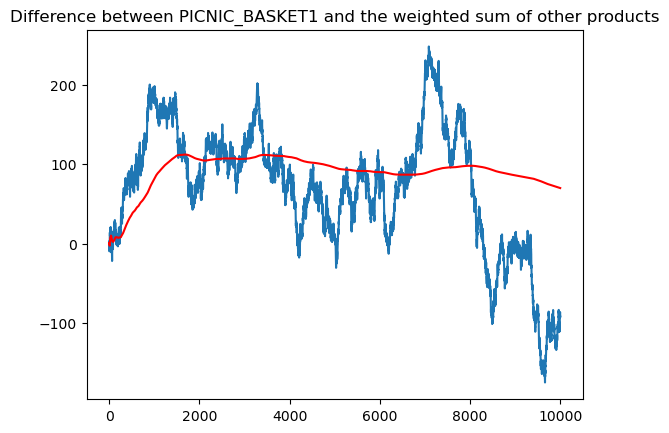

In [5]:
df['mid_price'] = (df['ask_price_1'] + df['bid_price_1']) / 2
df['swmid'] = size_weighted_mid_price(df)
basket = df[df['product'] == 'PICNIC_BASKET1']
crois = df[df['product'] == 'CROISSANTS']
jam = df[df['product'] == 'JAMS']
djembe = df[df['product'] == 'DJEMBES']

# Reset indices to align the DataFrames
basket = basket.reset_index(drop=True)
crois = crois.reset_index(drop=True)
jam = jam.reset_index(drop=True)
djembe = djembe.reset_index(drop=True)

# Perform the calculation
diff = basket['swmid'] - (6 * crois['swmid'] + 3 * jam['swmid'] + djembe['swmid'])

running_mean = diff.rolling(window=80000, min_periods=0).mean()
# Plot the result
plt.plot(diff)
plt.plot(running_mean, color='red', label='Running Mean')
plt.title('Difference between PICNIC_BASKET1 and the weighted sum of other products')
plt.show()

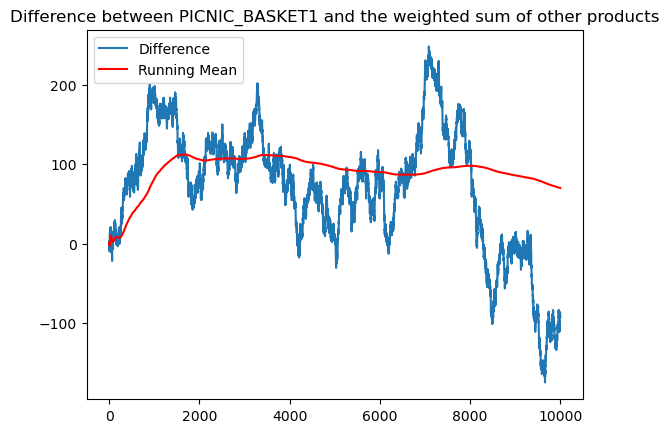

: 

In [ ]:
# Now perform ADF stationarity testing on `diff`
n_timesteps = 100  # or any number of timesteps you want to test on
adf_results = adf_stationarity_test(diff, n_timesteps)

# Print the ADF test results
print("ADF Test Results (first {} timesteps):".format(n_timesteps))
for key, value in adf_results.items():
    print(f"{key}: {value}")
